# Transfer learning with MobileNetv2

# Imports

In [1]:
import torch
from torch import nn

from torch.utils.data import DataLoader, random_split

import torchvision

from torchvision.transforms import v2

from pathlib import Path

from matplotlib import pyplot as plt

from PIL import Image

import pandas as pd

import time

import multiprocessing

# Functions

In [2]:
def find_device():
    device = 'cpu'

    if torch.cuda.is_available():
        device = 'cuda'
    elif torch.backends.mps.is_available():
        device = 'mps'

    return device


def load_data(data_path: Path) -> [DataLoader, DataLoader, DataLoader]:
    tr = torchvision.transforms.Compose([
        torchvision.transforms.Resize([224, 224]),
        torchvision.transforms.ToTensor(), ])

    image_folder = torchvision.datasets.ImageFolder(data_path, transform=tr)

    g1 = torch.Generator().manual_seed(20)
    train_data, val_data, test_data = random_split(image_folder, [0.6, 0.2, 0.2], g1)

    train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=multiprocessing.cpu_count())
    val_data_loader = DataLoader(val_data, batch_size=32, shuffle=True, num_workers=multiprocessing.cpu_count())
    test_data_loader = DataLoader(test_data, batch_size=32, shuffle=True, num_workers=multiprocessing.cpu_count())

    return train_data_loader, val_data_loader, test_data_loader


def load_model(device: str = 'cuda') -> nn.Module:
    model = torchvision.models.mobilenet_v2(
        weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False

    model.classifier[1] = nn.Linear(1280, 15)
    model = model.to(device)

    return model


def train(model: nn.Module,
          data_loader: DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          device: str = 'cuda',
          tensorboard_writer=None,
          epoch: int = 0) -> list[float]:
    model = model.to(device)
    model.train()

    running_loss = 0
    i_c = 0
    number_of_batches = len(data_loader)

    losses = []

    t1 = time.time()
    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        prediction = model(images)
        loss = loss_fn(prediction, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        i_c += 1
        if (i % 10 == 9) or i == number_of_batches - 1:
            time_taken = time.time() - t1
            remaining_time = (time_taken / i_c) * (number_of_batches - i)
            remaining_minutes = int(remaining_time // 60)
            remaining_seconds = int(remaining_time % 60)
            print(f'\r{i + 1}/{number_of_batches}, loss = {loss.item():>4f}, time_taken: {time_taken:.2f}'
                  f', predicting_remaining_time: {remaining_minutes:d}m {remaining_seconds:02d}s',
                  end='')
            if tensorboard_writer:
                tensorboard_writer.add_scalar('training loss', running_loss / i_c, epoch * number_of_batches + i)
            losses.append(running_loss / i_c)
            running_loss = 0
            i_c = 0
            t1 = time.time()
    print()

    return losses


def evaluate(model: nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn: nn.Module,
             device: str = 'cuda') -> tuple[torch.float, torch.float]:
    model = model.to(device)
    model.eval()

    data_size = len(data_loader.dataset)
    number_of_batches = len(data_loader)

    i_c = 0

    loss = 0
    correct = 0
    with torch.no_grad():
        t1 = time.time()
        for i, (images, labels) in enumerate(data_loader):
            images = images.to(device)
            labels = labels.to(device)

            prediction = model(images)
            loss += loss_fn(prediction, labels).item()
            correct += (prediction.argmax(1) ==
                        labels).type(torch.float).sum().item()

            i_c += 1
            if (i % 10 == 9) or i == number_of_batches - 1:
                time_taken = time.time() - t1
                remaining_time = (time_taken / i_c) * (number_of_batches - i)
                remaining_minutes = int(remaining_time // 60)
                remaining_seconds = int(remaining_time % 60)
                print(f'\r{i + 1}/{number_of_batches}, time_taken: {time_taken:.2f}'
                      f', predicting_remaining_time: {remaining_minutes:d}m {remaining_seconds:02d}s',
                      end='')
                i_c = 0
                t1 = time.time()

        loss /= number_of_batches
        correct /= data_size

    print()

    return correct, loss


def predict(model: nn.Module,
            test_data_path: Path,
            device: str = 'cuda') -> pd.DataFrame:
    model = model.to(device)
    model.eval()

    tr = v2.Compose(
        [v2.Resize([90, 160]),
         v2.ToImage(),
         v2.ToDtype(torch.float32, True), ]
    )

    image_paths = test_data_path.rglob('*.jpg')

    result = {'image_path': [], 'prediction': []}

    with torch.no_grad():
        for image_path in image_paths:
            image = Image.open(image_path)

            image_tensor = tr(image).to(device)
            image_tensor = image_tensor.unsqueeze(0)

            with torch.no_grad():
                prediction = model(image_tensor)
            prediction = torch.argmax(prediction)

            result['image_path'].append(
                f'{image_path.parent.name} / f{image_path.name}')
            result['prediction'].append(prediction.detach().cpu().numpy())

    return pd.DataFrame(result)


def plot_standard(ax: plt.Axes, data: list[float], name: str) -> plt.Axes:
    ax.set_title(name)
    ax.plot(data)

    ax.set_xlabel('Epochs')
    ax.set_ylabel(name)

    return ax


# Device

In [3]:
device = find_device()

print(f'device: {device}')

device: cuda


# Data

In [4]:
data_path = Path('../input/animal-data')

In [5]:
train_data_loader, valid_data_loader, test_data_loader = load_data(data_path)

tensor(0)


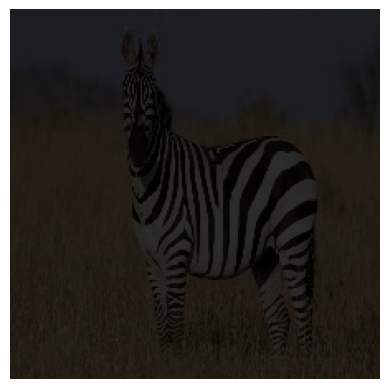

In [6]:
for tensor_image, label in train_data_loader:
    figure, axes = plt.subplots(1,1)

    axes.imshow(torchvision.transforms.ToPILImage()(tensor_image[0]))
    axes.set_axis_off()
    print(label[0])
    break

# Model

In [7]:
model = load_model(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 81.6MB/s]


# Train

In [8]:
losses = []

train_accuracies = []
train_losses = []

valid_accuracies = []
valid_losses = []

for epoch in range(5):
    print(f'in epoch: {epoch}')
    l1 = train(model, train_data_loader, loss_fn,
               optimizer, device)
    losses += l1

    accuracy, loss = evaluate(model, train_data_loader, loss_fn, device)
    print(f'train -> accuracy: {accuracy:.2f}, loss: {loss:.2f}')

    train_accuracies.append(accuracy)
    train_losses.append(loss)

    accuracy, loss = evaluate(model, valid_data_loader, loss_fn, device)
    print(f'validation -> accuracy: {accuracy:.2f}, loss: {loss:.2f}')

    valid_accuracies.append(accuracy)
    valid_losses.append(loss)

    print('********')

in epoch: 0
37/37, loss = 0.000223, time_taken: 0.33, predicting_remaining_time: 0m 00s
37/37, time_taken: 0.18, predicting_remaining_time: 0m 00s
train -> accuracy: 1.00, loss: 0.00
13/13, time_taken: 0.09, predicting_remaining_time: 0m 00s
validation -> accuracy: 1.00, loss: 0.00
********
in epoch: 1
37/37, loss = 0.000036, time_taken: 0.20, predicting_remaining_time: 0m 00s
37/37, time_taken: 0.18, predicting_remaining_time: 0m 00s
train -> accuracy: 1.00, loss: 0.00
13/13, time_taken: 0.06, predicting_remaining_time: 0m 00s
validation -> accuracy: 1.00, loss: 0.00
********
in epoch: 2
37/37, loss = 0.000010, time_taken: 0.19, predicting_remaining_time: 0m 00s
37/37, time_taken: 0.18, predicting_remaining_time: 0m 00s
train -> accuracy: 1.00, loss: 0.00
13/13, time_taken: 0.07, predicting_remaining_time: 0m 00s
validation -> accuracy: 1.00, loss: 0.00
********
in epoch: 3
37/37, loss = 0.000019, time_taken: 0.20, predicting_remaining_time: 0m 00s
37/37, time_taken: 0.18, predicting_

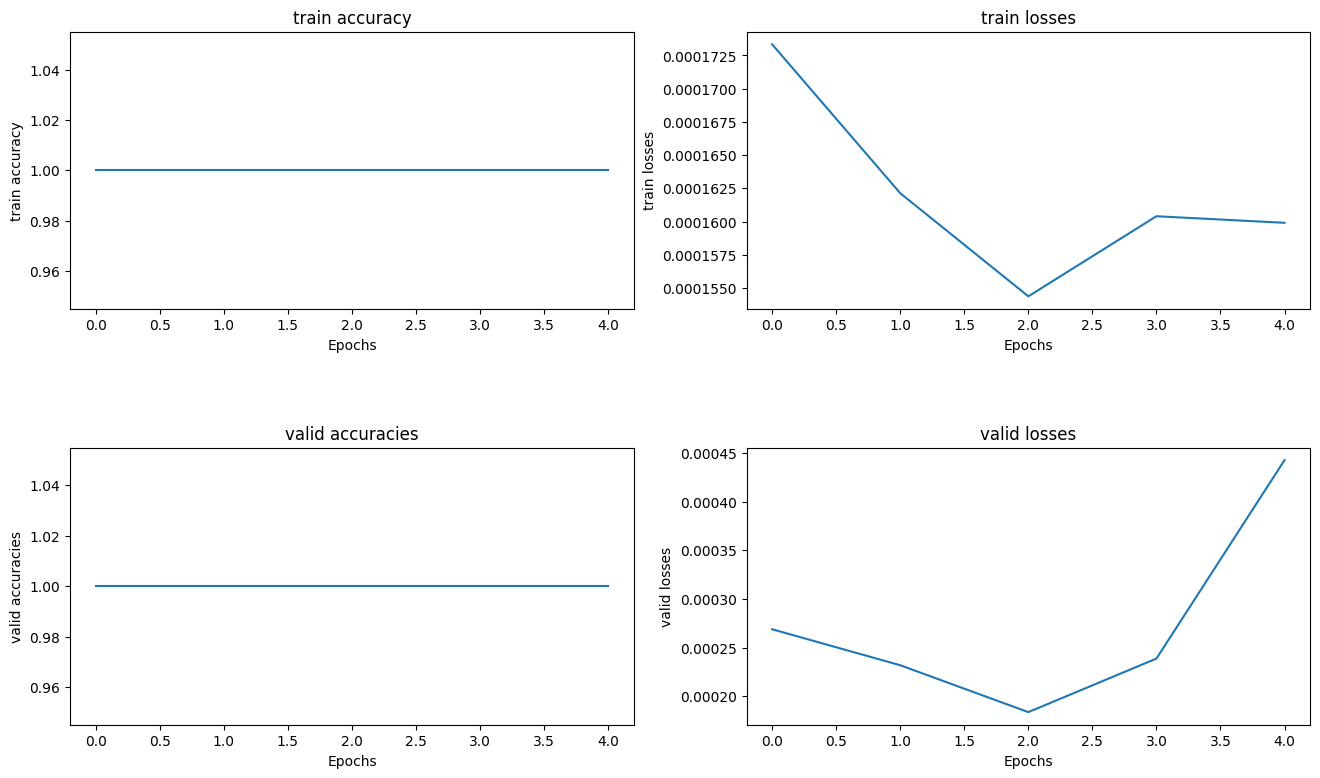

In [9]:
figure, axes = plt.subplots(2, 2, figsize=(16, 9))
figure.subplots_adjust(hspace=0.5)
plot_standard(axes[0, 0], train_accuracies, 'train accuracy')
plot_standard(axes[0, 1], train_losses, 'train losses')
plot_standard(axes[1, 0], valid_accuracies, 'valid accuracies')
plot_standard(axes[1, 1], valid_losses, 'valid losses')

plt.show()

# Test

In [10]:
accuracy, loss = evaluate(model, test_data_loader, loss_fn, device=device)
print(f'test -> accuracy: {accuracy:.2f}, loss: {loss:.2f}')

13/13, time_taken: 0.09, predicting_remaining_time: 0m 00s
test -> accuracy: 1.00, loss: 0.00
